In [1]:
pip install torch torchaudio

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torch in c:\users\ahraj\anaconda3\lib\site-packages (2.1.2)



In [20]:
import pandas as pd
import warnings
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from torchaudio import transforms
from glob import glob
from tqdm import tqdm
import time
import librosa

In [7]:
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
audio_files = glob('D:\\proj\\*\\*\\*.wav')    # to import multiple files.

In [23]:
feature_df = pd.DataFrame(columns=["features", "label"])

for audio_file in tqdm(audio_files, desc="Processing audio files", unit="file"):   #tqdm to show the progress of files for feature extraction.
    
    with warnings.catch_warnings():      
        warnings.simplefilter("ignore")
    
        audio_input, sr = torchaudio.load(audio_file, normalize=True)
        input_values = processor(audio_input.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values

        with torch.no_grad():
            features = model(input_values).last_hidden_state

        avg_features = torch.mean(features, dim=1).squeeze().numpy()


        feature_df = feature_df._append({"features": avg_features, "label": label}, ignore_index=True)

feature_df.to_csv('ua_speech_features_new.csv', index=False)

Processing audio files: 100%|██████████| 25/25 [00:00<00:00, 27.84file/s]


'\nfor audio_file in tqdm(audio_files, desc="Processing audio files", unit="file"):\n    \n    with warnings.catch_warnings():\n        warnings.simplefilter("ignore")\n    \n        audio_input, sr = torchaudio.load(audio_file, normalize=True)\n        input_values = processor(audio_input.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values\n\n        with torch.no_grad():\n            features = model(input_values).last_hidden_state\n\n        avg_features = torch.mean(features, dim=1).squeeze().numpy()\n\n\n        feature_df = feature_df._append({"features": avg_features, "label": label}, ignore_index=True)\n\nfeature_df.to_csv(\'ua_speech_features_new.csv\', index=False)'

In [13]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('C:\\Users\\ahraj\\ua_speech_features.csv')

In [4]:
def add_commas(array_str):            # for cleaning, i.e., empty spaces
    array_str = array_str.strip('[').strip(']')
    array_str = array_str.replace(' ', ',').replace(',,', ',').replace(',,', ',')
    if array_str.startswith(','):
        array_str = array_str[1:]    
    return '[' + array_str + ']'


df['features'] = df['features'].apply(add_commas)
df = df[df['features'].apply(lambda x: len(x) > 0)]
df['features'] = df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).values

X = df['features']
y = df['label']

C:\Users\ahraj\AppData\Local\Temp\ipykernel_14364\4066282559.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  df['features'] = df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).values


In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [41]:
X_train = X_train[0:800]
y_train = y_train[0:800]
X_test = X_test[0:200]
y_test = y_test[0:200]

In [51]:
X

0           [0.0201109052]
1          [0.00813677162]
2          [-0.0149907563]
3          [0.00269836048]
4          [-0.0102649061]
                ...       
143560    [-0.00625718152]
143561     [-0.0179482885]
143562     [-0.0212299637]
143563      [0.0292195994]
143564    [-0.00592626585]
Name: features, Length: 143565, dtype: object

In [42]:
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [43]:
X_train.shape

(800, 1)

In [44]:
svm_classifier = SVC(kernel='rbf', C=1.0)      #rbf for non-linear data
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

'''from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)'''

'''from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)'''

'from sklearn.naive_bayes import GaussianNB\ngnb = GaussianNB()\ngnb.fit(X_train, y_train)\ny_pred = gnb.predict(X_test)'

In [45]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1])

In [46]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("Classification Report:")
print(report)

Accuracy: 56.00000000000001
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.84      0.66       104
           1       0.60      0.26      0.36        96

    accuracy                           0.56       200
   macro avg       0.57      0.55      0.51       200
weighted avg       0.57      0.56      0.52       200



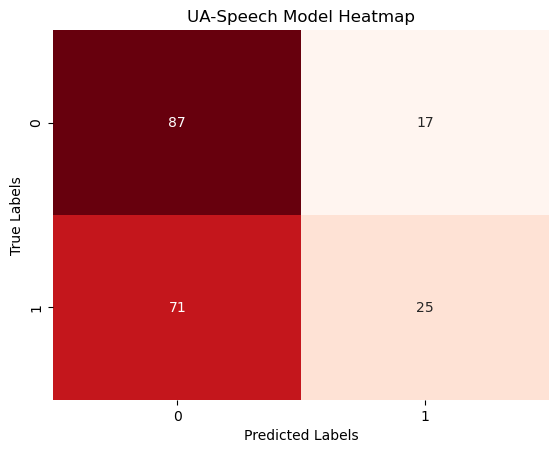

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('UA-Speech Model Heatmap')
plt.show()